# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import scipy.stats as st
import random
from tqdm import tqdm

from model import *
from dataset import *
from utils import *

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2, 
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Load model

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
def load_model():
    model = MyModel(input_dim=hyperparams['input_dim'], hidden_dim=hyperparams['hidden_dim'],
                    output_dim=hyperparams['output_dim']).to(device)
    checkpoint = torch.load('Task1_multiTask.pth.tar', map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

# Load data

In [4]:
dataset = torch.load('./two_links_arm_test')
adapt_data = [data['adapt'] for data in dataset]
test_data = [data['test'] for data in dataset]

# Adaptation 

In [5]:
def smcd(model: MyModel, T, N, adapt_data, d=0.05):
    '''
    model: neural network
    T: adaptation timestep
	N: particle numbers
	adapt_data: as name
	d: flip rate
	'''
    q = adapt_data['angle']
    z = adapt_data['noisy_pos']
    # z = adapt_data['true_pos']
    n_features = model.get_dropout_mask().shape[0]
	# initialize M_0
    # M = np.random.randint(low=0,high=2,size=(n_features, N))
    M = np.ones((n_features, N), dtype=np.int8)
    M_best = np.ones(n_features)
    assert T <= q.shape[-1], f'T should be less than {q.shape[-1]}'
    assert not model.training, f'please call model.eval()'
    M_bests = []
    for t in tqdm(range(T)):
        M = flip(M,d)
        M[:,0] = M_best # replace one particle by the last best one (no mutation for the last champion particle)
        w = []
        for i in range(N):
            model.update_dropout_mask(M[:,i])
            x_i = model(q[:,t].to(device, dtype=torch.float32)).detach().numpy()
            w_i = st.multivariate_normal.pdf(z[:,t].detach().numpy(), mean=x_i, cov=0.001)
            w.append(w_i)
        # print(w)
        # N_eff = int(1 / np.sum((np.asarray(w)) ** 2))
        # print(N_eff)
        resample_index = resample(range(N), w)
        M = np.take(M, resample_index, axis=1)
        M_best = (M.mean(axis=1) > 0.5).astype(np.int_)
        M_bests.append(M_best)
    return M_bests

In [6]:
def adapt_smcd(adapt_timestep=10, n_particles=300):
    losses = []
    # losses_no_adaptation = []
    criterion = nn.MSELoss()
    M_best_per_task = []
    for i in range(len(adapt_data)):
        model = load_model()
        q = adapt_data[i]['angle'].to(torch.float32).swapaxes(1,0)
        x = adapt_data[i]['true_pos'].to(torch.float32).swapaxes(1,0)
        # x_noadapt = model(q).detach()
        
        M_best = smcd(model, adapt_timestep, n_particles, adapt_data[i], d=0.05)
        M_best_per_task.append(M_best[-1])
        model.update_dropout_mask(M_best[-1])
        x_pred = model(q).detach()
        
        loss = criterion(x_pred, x)
        # loss_no_adapt = criterion(x_noadapt, x)
        print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, limb length is {dataset.l[i]}")
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, No adaptation loss is {round(loss_no_adapt.item(), 3)}, limb length is {dataset.l[i]}")
        losses.append(loss)
        # losses_no_adaptation.append(loss_no_adapt)
    return losses, M_best_per_task

In [7]:
losses, M_best_per_task = adapt_smcd()
np.mean(losses)

100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


For 0th task, loss after adaptation is 0.187, limb length is [1.30406567 0.62399069]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 1th task, loss after adaptation is 0.011, limb length is [0.73451951 0.87818549]


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


For 2th task, loss after adaptation is 0.025, limb length is [1.1227808 1.171541 ]


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


For 3th task, loss after adaptation is 0.498, limb length is [1.49445819 0.17971192]


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


For 4th task, loss after adaptation is 0.129, limb length is [0.84613705 1.25956584]


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


For 5th task, loss after adaptation is 0.094, limb length is [0.90802565 1.32361601]


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


For 6th task, loss after adaptation is 0.03, limb length is [0.77498269 0.72469866]


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


For 7th task, loss after adaptation is 0.144, limb length is [1.28592259 0.73538282]


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


For 8th task, loss after adaptation is 0.006, limb length is [1.05904967 0.92188386]


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


For 9th task, loss after adaptation is 0.012, limb length is [0.88501947 0.72679485]


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


For 10th task, loss after adaptation is 0.002, limb length is [0.93319508 1.00753804]


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


For 11th task, loss after adaptation is 0.096, limb length is [1.31289959 1.25051428]


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


For 12th task, loss after adaptation is 0.206, limb length is [1.24672587 1.58416192]


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


For 13th task, loss after adaptation is 0.042, limb length is [0.45287948 0.83878246]


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


For 14th task, loss after adaptation is 0.02, limb length is [0.8190966  0.90762601]


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


For 15th task, loss after adaptation is 0.072, limb length is [0.55099161 1.06013007]


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


For 16th task, loss after adaptation is 0.013, limb length is [0.51433327 0.66866756]


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


For 17th task, loss after adaptation is 0.039, limb length is [0.6304416  0.95845014]


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


For 18th task, loss after adaptation is 0.029, limb length is [0.68528397 0.98123939]


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


For 19th task, loss after adaptation is 0.141, limb length is [1.08834101 1.40968333]


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


For 20th task, loss after adaptation is 0.159, limb length is [1.0503184  0.31652623]


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


For 21th task, loss after adaptation is 0.124, limb length is [0.7155408  1.28327679]


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


For 22th task, loss after adaptation is 0.456, limb length is [1.63132939 0.34012673]


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


For 23th task, loss after adaptation is 0.001, limb length is [0.99584074 0.98020282]


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


For 24th task, loss after adaptation is 0.003, limb length is [0.78957266 0.86249624]


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


For 25th task, loss after adaptation is 0.022, limb length is [0.87071889 1.15432126]


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


For 26th task, loss after adaptation is 0.205, limb length is [0.45625869 1.31711353]


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


For 27th task, loss after adaptation is 0.041, limb length is [1.21890683 0.96269787]


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


For 28th task, loss after adaptation is 0.09, limb length is [0.77265263 1.18949149]


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


For 29th task, loss after adaptation is 0.015, limb length is [0.77808927 0.91626881]


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


For 30th task, loss after adaptation is 0.022, limb length is [0.66521506 0.82474456]


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


For 31th task, loss after adaptation is 0.3, limb length is [0.11389979 1.30474315]


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


For 32th task, loss after adaptation is 0.175, limb length is [1.27685789 0.73197669]


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


For 33th task, loss after adaptation is 0.018, limb length is [0.74910273 0.60403601]


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


For 34th task, loss after adaptation is 0.385, limb length is [0.81797316 1.59330494]


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


For 35th task, loss after adaptation is 0.083, limb length is [1.22373458 1.30844083]


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


For 36th task, loss after adaptation is 0.01, limb length is [1.08455492 0.93322153]


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


For 37th task, loss after adaptation is 0.03, limb length is [0.76005791 1.07930932]


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


For 38th task, loss after adaptation is 0.028, limb length is [0.88736757 0.57968894]


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


For 39th task, loss after adaptation is 0.318, limb length is [0.95225539 1.69465423]


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


For 40th task, loss after adaptation is 0.004, limb length is [1.03984066 0.9225469 ]


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


For 41th task, loss after adaptation is 0.069, limb length is [0.81359973 1.20785134]


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


For 42th task, loss after adaptation is 0.019, limb length is [0.84120093 1.05400036]


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


For 43th task, loss after adaptation is 0.002, limb length is [0.9420061  0.91529251]


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


For 44th task, loss after adaptation is 0.296, limb length is [1.42713676 0.41357221]


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


For 45th task, loss after adaptation is 0.016, limb length is [0.97685968 1.15726718]


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


For 46th task, loss after adaptation is 0.093, limb length is [1.06781162 0.46290377]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 47th task, loss after adaptation is 0.239, limb length is [1.48878415 0.96988886]


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


For 48th task, loss after adaptation is 0.046, limb length is [1.04707093 1.2191607 ]


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


For 49th task, loss after adaptation is 0.162, limb length is [0.63415179 1.28737637]


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


For 50th task, loss after adaptation is 0.031, limb length is [0.97101713 0.63959654]


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


For 51th task, loss after adaptation is 0.004, limb length is [0.82263817 0.90140273]


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


For 52th task, loss after adaptation is 0.097, limb length is [1.20154034 1.40447519]


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


For 53th task, loss after adaptation is 0.019, limb length is [1.07920914 0.8221939 ]


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


For 54th task, loss after adaptation is 0.045, limb length is [1.07501188 0.6906436 ]


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


For 55th task, loss after adaptation is 0.171, limb length is [1.46284041 1.40075093]


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


For 56th task, loss after adaptation is 0.026, limb length is [0.75997962 1.05385878]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 57th task, loss after adaptation is 0.009, limb length is [1.11975047 1.0145246 ]


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


For 58th task, loss after adaptation is 0.459, limb length is [1.7253088  1.46952956]


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


For 59th task, loss after adaptation is 0.048, limb length is [0.79848925 1.16909152]


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


For 60th task, loss after adaptation is 0.125, limb length is [0.6410616  1.23547814]


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


For 61th task, loss after adaptation is 0.084, limb length is [0.96128854 0.36390703]


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


For 62th task, loss after adaptation is 0.012, limb length is [0.96806955 1.12896362]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 63th task, loss after adaptation is 0.081, limb length is [1.28785763 1.26260985]


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


For 64th task, loss after adaptation is 0.009, limb length is [0.9074814 1.0880285]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 65th task, loss after adaptation is 0.01, limb length is [0.96737193 1.11883405]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 66th task, loss after adaptation is 0.004, limb length is [0.9301901  1.04755806]


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


For 67th task, loss after adaptation is 0.094, limb length is [0.96153332 0.34764453]


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


For 68th task, loss after adaptation is 0.089, limb length is [1.23646935 0.87502107]


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


For 69th task, loss after adaptation is 0.101, limb length is [1.27363217 1.28913845]


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


For 70th task, loss after adaptation is 0.017, limb length is [1.00569859 0.86933517]


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


For 71th task, loss after adaptation is 0.179, limb length is [0.69003907 1.3469162 ]


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


For 72th task, loss after adaptation is 0.02, limb length is [0.80907748 0.5651437 ]


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


For 73th task, loss after adaptation is 0.004, limb length is [0.96886028 1.06436636]


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


For 74th task, loss after adaptation is 0.017, limb length is [0.50122749 0.63701923]


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


For 75th task, loss after adaptation is 0.161, limb length is [0.0994944 0.8410024]


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


For 76th task, loss after adaptation is 0.494, limb length is [1.80902867 0.62447148]


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


For 77th task, loss after adaptation is 0.066, limb length is [1.24956418 0.96798579]


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


For 78th task, loss after adaptation is 0.22, limb length is [1.48445369 1.40762238]


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


For 79th task, loss after adaptation is 0.002, limb length is [0.95719588 0.89456197]


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


For 80th task, loss after adaptation is 0.078, limb length is [1.29091638 0.82773174]


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


For 81th task, loss after adaptation is 0.006, limb length is [0.81471358 0.72785575]


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


For 82th task, loss after adaptation is 0.11, limb length is [1.03618054 1.39417404]


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


For 83th task, loss after adaptation is 0.176, limb length is [0.68546477 1.30967401]


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


For 84th task, loss after adaptation is 0.037, limb length is [1.12903137 0.90771228]


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


For 85th task, loss after adaptation is 0.044, limb length is [1.25274149 1.14449399]


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


For 86th task, loss after adaptation is 0.302, limb length is [0.59676629 1.46655745]


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


For 87th task, loss after adaptation is 0.009, limb length is [1.11345045 1.03058622]


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


For 88th task, loss after adaptation is 0.117, limb length is [1.08628635 1.43785257]


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


For 89th task, loss after adaptation is 0.124, limb length is [0.70399814 1.24647768]


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


For 90th task, loss after adaptation is 0.019, limb length is [1.118202   1.11383129]


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


For 91th task, loss after adaptation is 0.102, limb length is [1.17625879 0.66072321]


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


For 92th task, loss after adaptation is 0.31, limb length is [1.50722186 0.7041939 ]


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


For 93th task, loss after adaptation is 0.052, limb length is [0.4761456  0.94608942]


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


For 94th task, loss after adaptation is 0.073, limb length is [0.73713896 1.11829923]


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


For 95th task, loss after adaptation is 0.045, limb length is [0.59866355 0.93078042]


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


For 96th task, loss after adaptation is 0.023, limb length is [0.56039492 0.60205355]


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


For 97th task, loss after adaptation is 0.004, limb length is [0.89490093 0.99899444]


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


For 98th task, loss after adaptation is 0.023, limb length is [1.192756   0.91870071]


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

For 99th task, loss after adaptation is 0.009, limb length is [0.55633126 0.67472012]


0.095897846

<StemContainer object of 3 artists>

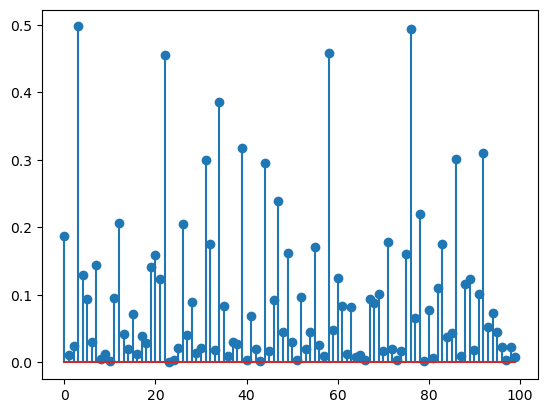

In [8]:
plt.stem(losses)

# Prediction

In [9]:
test_data[0].keys()

dict_keys(['init_angle', 'init_pos', 'target_pos', 'true_pos', 'noisy_pos'])

In [10]:
def plot_trace(t, start=0, end=-1):
	# init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	# plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='true_pos')
	plt.legend()

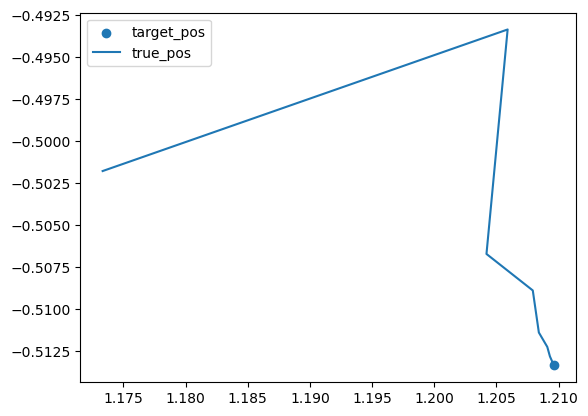

In [11]:
plot_trace(test_data[0], 0, 50)

In [12]:
def test_smcd(mask_per_task, n_tasks = -1):
	trace_pred = [[] for i in range(len(test_data))]
	trace_true = [[] for i in range(len(test_data))]
	with tqdm(test_data[0:n_tasks], unit='task')as tepoch:
		for i, task in enumerate(tepoch):
			model = load_model()
			q0 = task['init_angle'].to(dtype=torch.float32)
			xg = task['target_pos']
			x_oracle = task['true_pos']
			model.update_dropout_mask(mask_per_task[i])
			q = q0
			u = 0
			l = dataset.l[i]
			for t in range(len(x_oracle)):
				x_pred = model(q).detach()
				# emit control from predicted position
				u = pd(q, x_pred, xg, u, k=[1,1e-2], l=l)
				q += u
				# remember to normalize
				q = np.mod(q, 2 * np.pi) - np.pi
				# the system evolve subject to control and real setting
				x_true = fk(q, l)
				trace_pred[i].append(x_pred.numpy())
				trace_true[i].append(x_true)	
	trace_pred = np.asarray(trace_pred)
	trace_true = np.asarray(trace_true)
	return trace_pred, trace_true


In [13]:
trace_pred, trace_true = test_smcd(M_best_per_task, 100)

100%|██████████| 100/100 [00:32<00:00,  3.06task/s]


In [17]:
def plot_trace(i, start=0, end=-1):
	# init_pos = t['init_pos'].numpy()
	t = test_data[i]
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='oracle_pos')
	plt.plot(trace_pred[i][start:end,0], trace_pred[i][start:end,1], label='pred_pos')
	plt.plot(trace_true[i][start:end,0], trace_true[i][start:end,1], label='true_pos')
	plt.legend()

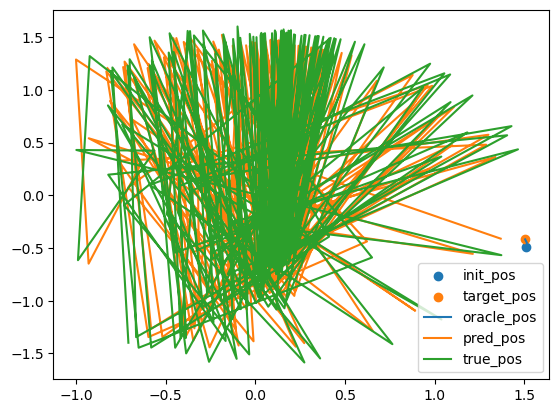

In [20]:
plot_trace(9)